In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from seqspace.utils import hamming_distance

from latticeproteins.conformations import Conformations
from latticeproteins.evolution import Evolution
from latticeproteins.fitness import Fitness
from latticeproteins.sequences import RandomSequence

from latticegpm.space import LatticeGenotypePhenotypeMap

from epistasis.models.nonlinear.regression import EpistasisNonlinearRegression
from epistasis.models.linear.regression import EpistasisLinearRegression
from epistasis.models.nonlinear.power import EpistasisPowerTransform

In [22]:
length = 15
temperature = 1.0
dGdependence= "fracfolded"
conf_database = Conformations(length)
fitness = Fitness(temperature, conf_database, dGdependence=dGdependence)

In [27]:
wildtype = "".join(RandomSequence(length))
popsize = 10
mutrate = 0.01
numsteps = 100
f = None
finalpop = Evolution(wildtype, fitness, popsize, mutrate, numsteps, file=f)
mutant = finalpop[0]
order = hamming_distance(wildtype, mutant)
print(order)

11


In [28]:
gpm = LatticeGenotypePhenotypeMap.from_mutant(wildtype, mutant, temperature=temperature)

In [29]:
model = EpistasisLinearRegression.from_gpm(gpm, order=order, model_type="global")
model.fit()

In [88]:
model = EpistasisPowerTransform.from_gpm(gpm, order=1, model_type="global", fix_linear=True)
model.fit()

/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:314: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
/Users/Zsailer/Documents/Research/projects/pkgs/epistasis/epistasis/models/nonlinear/power.py:12: RuntimeWarning: invalid value encountered in power
  first = (x+A)**lmbda


In [94]:
np.unique(model.gpm.conformations)

array(['URDDDLULDLUURU', 'URDDLDRRDRUULU', 'URDRRULURULLDL',
       'URRRDLLDLDRRUR', 'UURDDRURDRUULL', 'UURDDRUURDDDLL',
       'UURDRDLDLDRRUR', 'UURDRDLDRDLLUL', 'UURRRDLLDRRRUU',
       'UUURRDLDDRURUU'], 
      dtype='<U14')

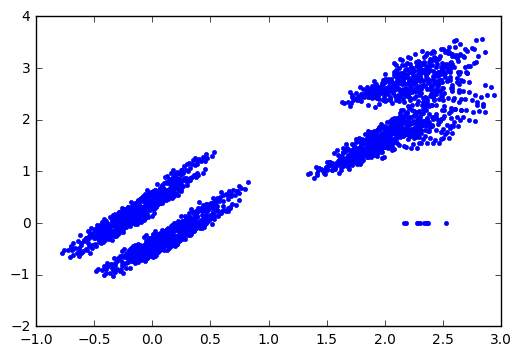

In [92]:
plt.plot(model.predict_linear(), model.gpm.phenotypes, '.')

<Container object of 2036 artists>

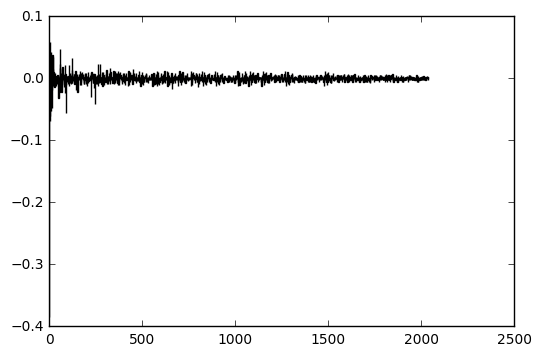

In [30]:
y = model.epistasis.values[order+1:]
x = range(len(y))
plt.bar(x, y, width=1)